In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import torch, torch.nn as nn
import torchvision

from copy import copy
from IPython import display
from IPython.display import clear_output
from PIL import Image
from skimage import color, transform
from sklearn.metrics import roc_auc_score
from time import time, sleep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

In [2]:
device = 'cpu'

In [3]:
fmnist_train_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True,
                                                     transform=transforms.Compose([transforms.ToTensor()]))
fmnist_test_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True, train=False,
                                                    transform=transforms.Compose([transforms.ToTensor()]))
fmnist_train_data = DataLoader(fmnist_train_set, batch_size=32)
fmnist_test_data = DataLoader(fmnist_test_set, batch_size=32)

In [4]:
mnist_train_set = torchvision.datasets.MNIST("./data_mnist", download=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
mnist_test_set = torchvision.datasets.MNIST("./data_mnist", download=True, train=False,
                                            transform=transforms.Compose([transforms.ToTensor()]))
mnist_train_data = DataLoader(mnist_train_set, batch_size=32)
mnist_test_data = DataLoader(mnist_test_set, batch_size=32)

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.block_1_conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.block_1_relu = nn.ReLU()
        self.block_1_max_pool = nn.MaxPool2d(kernel_size=2)

        self.block_2_conv = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.block_2_relu = nn.ReLU()
        self.block_2_max_pool = nn.MaxPool2d(kernel_size=2)
        self.block_2_batch_norm = nn.BatchNorm2d(num_features=16)

        self.block_3_flatten = nn.Flatten()
        self.block_3_linear = nn.Linear(in_features=400, out_features=100)
        self.block_3_relu = nn.ReLU()

        self.block_4_linear = nn.Linear(in_features=100, out_features=10)
        self.block_4_log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.block_1_conv(x)
        x = self.block_1_relu(x)
        x = self.block_1_max_pool(x)

        x = self.block_2_conv(x)
        x = self.block_2_relu(x)
        x = self.block_2_max_pool(x)
        x = self.block_2_batch_norm(x)

        x = self.block_3_flatten(x)
        x = self.block_3_linear(x)
        x = self.block_3_relu(x)

        x = self.block_4_linear(x)
        x = self.block_4_log_softmax(x)
        return x

In [6]:
def validate(teacher, student, data):
    teacher.eval()
    student.eval()
    total_img = 0
    loss = 0
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            total_img += len(images)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss += reverse_kl(teacher_pred, student_pred).item()
    return round(loss / total_img, 5)

In [7]:
def plot_results(train_log, val_log, test_log):
    clear_output(wait=True)
    print("Epoch", len(train_log))
    print("Train loss:\t", train_log[-1])
    print("Val loss:\t", val_log[-1])
    print("Test loss:\t", test_log[-1])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(train_log, label='train loss', c='b')
    ax1.plot(val_log, label='val loss', c='r')
    ax1.grid()
    ax1.legend(loc='best')

    ax2.plot(test_log, label='test_loss', c='g')
    ax2.legend(loc='best')
    ax2.grid()
    plt.show()

In [8]:
def cross_entroy_with_logits(teacher_pred, student_pred):
    return -torch.sum(torch.exp(teacher_pred) * student_pred, dim=1).mean()

In [9]:
def forward_kl(teacher_pred, student_pred):
    return torch.sum(torch.exp(teacher_pred) * (teacher_pred - student_pred))

In [10]:
def reverse_kl(teacher_pred, student_pred):
    return torch.sum(torch.exp(student_pred) * (student_pred - teacher_pred))

In [11]:
def symmetrized_kl(teacher_pred, student_pred):
    return forward_kl(student_pred, teacher_pred) + revrse_kl(student_pred, teacher_pred)

In [12]:
def train(teacher, student, optimizer, train_log, val_log, test_log, num_epochs=30, batch_size=32):
    for epoch in range(num_epochs):
        teacher.train()
        student.train()
        for images, _ in tqdm(fmnist_train_data):
            # Transfering images and labels to GPU if available
            images = images.view(-1, 1, 28, 28).to(device)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss = reverse_kl(student_pred, teacher_pred)
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_log.append(validate(teacher, student, fmnist_train_data))
        val_log.append(validate(teacher, student, fmnist_test_data))
        test_log.append(validate(teacher, student, mnist_train_data))
        plot_results(train_log, val_log, test_log)

In [13]:
train_log = []
val_log = []
test_log = []

In [14]:
teacher = ConvNet().to(device)
student = ConvNet().to(device)

In [15]:
optimizer = torch.optim.Adam(student.parameters(), lr=0.0001)

Epoch 50
Train loss:	 0.00184
Val loss:	 0.00216
Test loss:	 0.02037


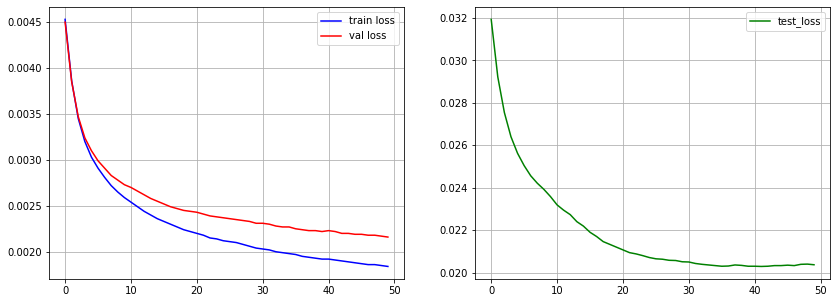

CPU times: user 2h 41min 21s, sys: 10min 4s, total: 2h 51min 25s
Wall time: 1h 59min 52s


In [16]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 100
Train loss:	 0.00166
Val loss:	 0.00206
Test loss:	 0.02027


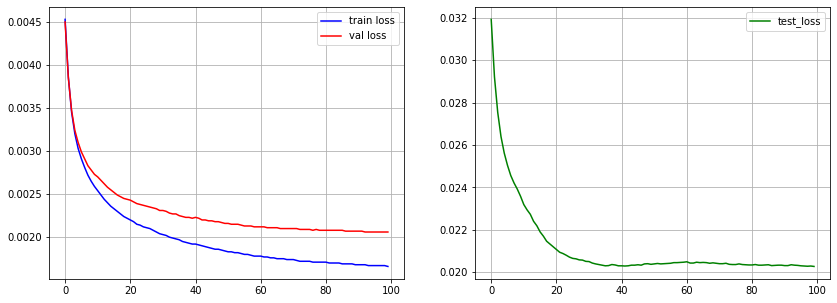

CPU times: user 2h 38min 53s, sys: 9min 25s, total: 2h 48min 19s
Wall time: 2h 5min 38s


In [17]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [18]:
def get_prediction_errors(teacher, student, data):
    teacher.eval()
    student.eval()
    loss = []
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss.append(reverse_kl(teacher_pred, student_pred).item())
    return loss

In [19]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))

In [20]:
y_true = [1] * len(mnist_prediction_errors) + [0] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.9888147366666666

Epoch 150
Train loss:	 0.00158
Val loss:	 0.00199
Test loss:	 0.02019


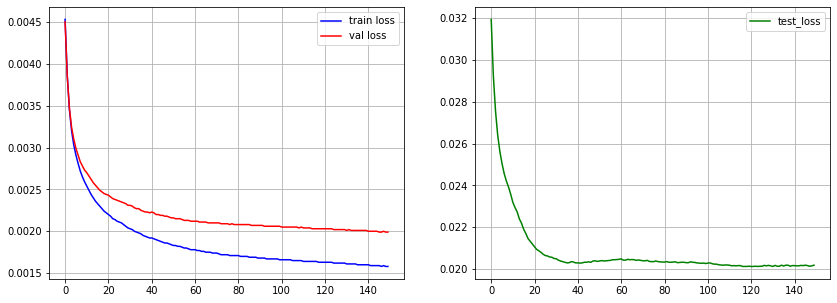

CPU times: user 2h 38min 6s, sys: 9min 50s, total: 2h 47min 57s
Wall time: 1h 56min 44s


In [21]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 200
Train loss:	 0.00152
Val loss:	 0.00192
Test loss:	 0.01977


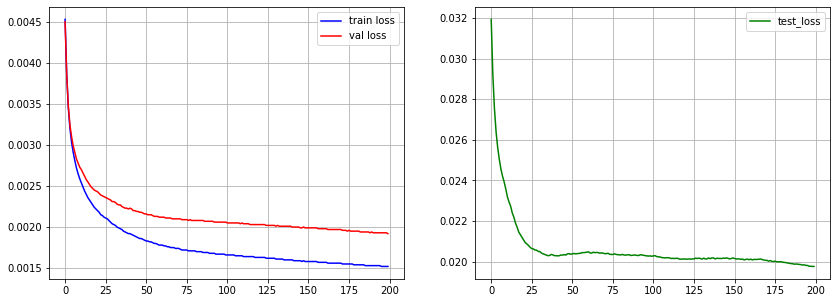

CPU times: user 2h 45min, sys: 10min 55s, total: 2h 55min 56s
Wall time: 1h 54min 51s


In [22]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 250
Train loss:	 0.00146
Val loss:	 0.00186
Test loss:	 0.01946


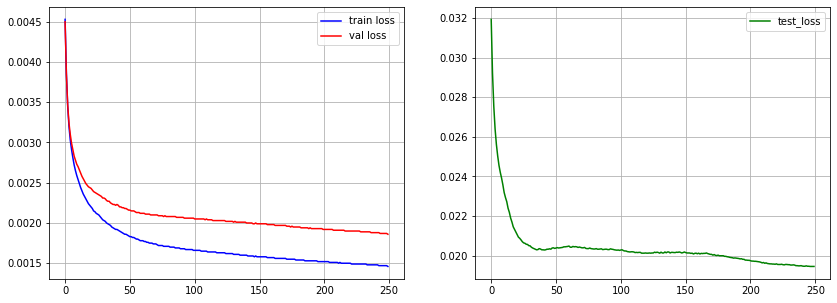

CPU times: user 3h 7min 29s, sys: 15min 22s, total: 3h 22min 52s
Wall time: 1h 47min 33s


In [23]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 350
Train loss:	 0.00138
Val loss:	 0.00178
Test loss:	 0.01914


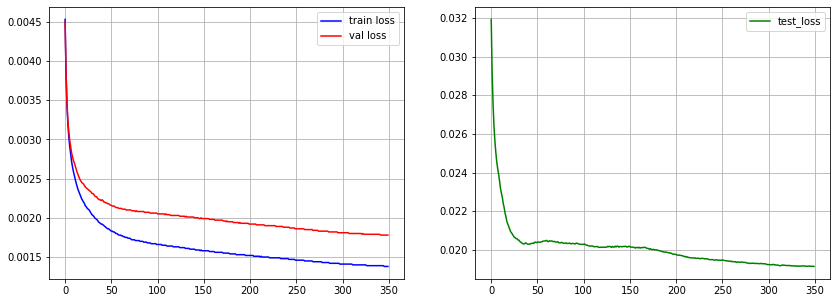

CPU times: user 10h 37min 24s, sys: 55min 50s, total: 11h 33min 14s
Wall time: 3h 2min 37s


In [24]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=100)

Epoch 500
Train loss:	 0.00132
Val loss:	 0.00173
Test loss:	 0.01913


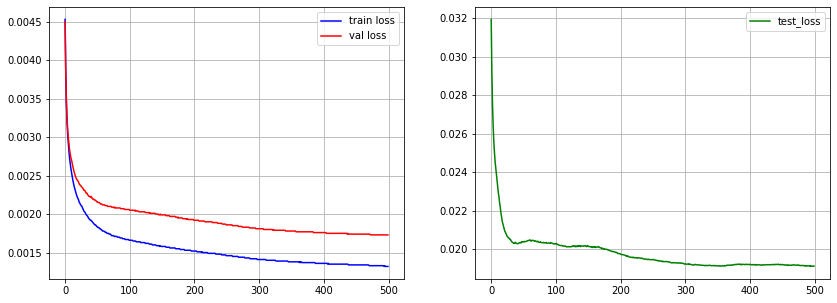

CPU times: user 11h 5min 57s, sys: 49min 42s, total: 11h 55min 39s
Wall time: 5h 35min 26s


In [25]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=150)

Epoch 519
Train loss:	 0.00132
Val loss:	 0.00172
Test loss:	 0.01914


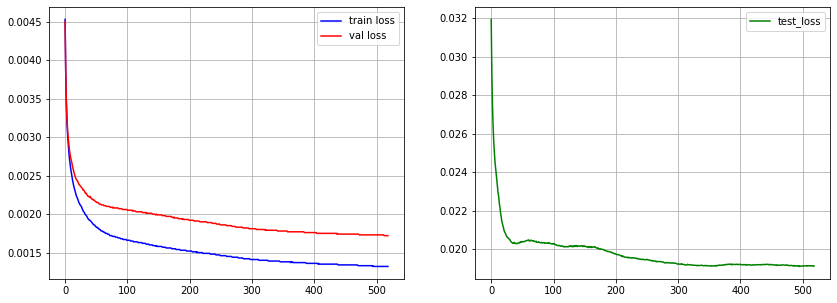

In [ ]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=100)